# Cloning Content

## Introduction

One request the Python API team has heard repeatedly from Web GIS administrators: What's the best way to move my content from a development Enterprise or organization to staging to production?

This Guide provides one possible roadmap for how to get content from one Web GIS to another - a template for demonstrating basic software concepts when transferring content so the workflow can be modified for other types of content and tailored for an administrator's particular need. 

The [`clone_items()`](https://developers.arcgis.com/python/api-reference/arcgis.gis.toc.html#arcgis.gis.ContentManager.clone_items) function on the ContentManger aims to create an exact duplicate of one item with all its uses and functionality from an original organizational deployment, whether ArcGIS Online, Enteprise, or Kubernetes to a second organizational deployment. The relationship between any supported, related, or resource items to the items being cloned must be considered when cloning an item. 

When talking about cloning items, let's establish some basic terminology.  Cloning can refer to the transfer of items between any organizational deployment, from either ArcGIS Enterprise, ArcGIS Online, or ArcGIS Enterprise for Kubernetes to any other deployment type. Rather than tangling ourselves up when trying to distinguish between these portal types while writing about them, we'll refer to organization where the content originates as the _source_ regardless of deployment type. We'll consider the organization to which we'll clone content as the _target_. 

This document illustrates the workflow of gathering _source_ items using a source administrator account, and cloning them into a _target_ administrator account.  More specifically, this guide walks through an approach of cloning [`hosted feature layers`](https://doc.arcgis.com/en/arcgis-online/manage-data/hosted-web-layers.htm) and [`web maps`](https://developers.arcgis.com/documentation/core-concepts/web-maps/). `Web Maps` can consume these layer items and their source services as operational layer building blocks. For information on each of these item types, please click the hyperlinks for each type.

This is an administrator workflow. Using administrator accounts guarantees all necessary privileges within the _source_ to access the item and any dependencies and within the _target_ to create the services and items. The target administrator subsequently can create user accounts and reassign item ownership and/or group membership according to need. This might also be the simplest workflow when the portal has users managed by an external identity store.

### Supported Items

As originally written, Python API developers designed the `clone_items()` function for transferring the following item types:
 * Hosted Web Applications built with Web AppBuilder or shared using Configurable App Templates
 * Web Maps
 * Hosted Feature Layers
 * Hosted Feature Layer Views
 * Feature Collections
 * Survey123 Forms
 * Workforce Projects
 * StoryMaps
   * See [Cloning Complex Items](../cloning-complex-apps)
 * Operation Views
 * Dashboards
   * See [Cloning Complex Apps](../cloning-complex-apps)
 * QuickCapture Projects
 * ArcGIS Notebooks 
 * Simple Types
   * Those items with a download option (see [Data files](https://developers.arcgis.com/rest/users-groups-and-items/items-and-item-types.htm) for items that may be in a Web GIS and available for download), including zipped file geodatabases and shapefiles, code samples, zip files, and packages amongst others.

`clone_items()` clones the dependencies for the more complex items listed above. For example, cloning an existing web application, clones the web map and all hosted feature layers referenced in the map.

`clone_items()` will not clone map services and image services. Since these services can be published to servers other than the hosted server in a configuration, it's impossible for the function to determine where to publish them in the target. As a result, these items will copy over, but will continue to point back to the original source URL. 

Let's work through examples of cloning individual items and inspect the results.


First, let's import the necessary libraries and connect to our source and target GIS:

### Import libraries

In [2]:
from pathlib import Path
import sys
import pandas as pd

from arcgis.gis import GIS, Item
from arcgis.env import active_gis
from arcgis.features import FeatureLayerCollection
from arcgis.mapping import WebMap

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


### Connect to source and target portals

Let's start from a discovery position as an administrator. We'll simulate an administrator who's been testing and developing using an [ArcGIS Online](https://doc.arcgis.com/en/arcgis-online/get-started/what-is-agol.htm) deployment as a development environment and wants to clone items into an on-premise [ArcGIS Enterprise](https://enterprise.arcgis.com/en/get-started/latest/windows/what-is-arcgis-enterprise-.htm) for further development.

In [3]:
source = GIS(profile="your_online_admin_profile")
print(source)

GIS @ https://geosaurus.maps.arcgis.com version:2023.3


In [4]:
target = GIS(profile="your_data_owner_profile")
print(target)

GIS @ https://example.url.com/portal version:10.3


### Get started with cloning

Let's start with an immediate demonstration of what `clone_items()` can do. We're logged in as an administrator and we'll `get()` a specific hosted feature layer item owned by one of the users in the _source_. We'll then clone it into the _target_ while utilizing the `owner` parameter to specify a particular `User` in the _target_ to own the cloned content. We can quickly examine the resulting `url` of the cloned feature layer to confirm the new item.

<Item title:"Arkansas Hospitals" type:Feature Layer Collection owner:api_data_owner>
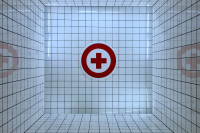

In [4]:
hosted_flyr = source.content.get("3213ff60f81c46a0a970ec31dde368ac")
hosted_flyr

In [5]:
hosted_flyr.url

'https://services7.arcgis.com/JEwYeAy2cc8qOe3o/arcgis/rest/services/Arkansas_Hospitals/FeatureServer'

In [7]:
cloned_flyr = target.content.clone_items(items=[hosted_flyr],
                                         owner="api_data_owner",
                                         folder="cloning_guide")

<Item title:"Arkansas Hospitals" type:Feature Layer Collection owner:api_data_owner>
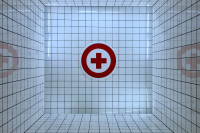

In [8]:
cloned_flyr[0]

In [9]:
cloned_flyr[0].url

'https://pythonapi.playground.esri.com/server/rest/services/Hosted/Arkansas_Hospitals/FeatureServer'

We can see that the `clone_items()` function returns a list containing the cloned items. Indexing the list we can see the operation created a new hosted feature layer in the _target_ organization owned by the `api_data_owner` user we entered as the `owner` argument. 

### Cloning multiple items simultaneously

We demonstrated above passing one item in the `items` parameter list. Now let's see how `clone_items()` will clone every item in the list. First let's [`search()`](https://developers.arcgis.com/python/api-reference/arcgis.gis.toc.html#arcgis.gis.ContentManager.search) the _source_ function for items owned by a particular user and clone the list items into our _target_ all at the same time.

In [10]:
tester_content = source.content.search(f"tags:disaster_testing AND owner:api_data_owner")
tester_content

[<Item title:"Earthquake Damage Map" type:Web Map owner:api_data_owner>,
 <Item title:"earthquakes_2" type:CSV owner:api_data_owner>,
 <Item title:"earthquakes_sample_data" type:CSV owner:api_data_owner>,
 <Item title:"earthquakes_2" type:Feature Layer Collection owner:api_data_owner>]

In [11]:
cloned_items = target.content.clone_items(items=tester_content, 
                                          folder=output_folder.name)

In [12]:
cloned_items

[<Item title:"earthquakes_2" type:Feature Layer Collection owner:api_data_owner>,
 <Item title:"earthquakes_2" type:CSV owner:api_data_owner>,
 <Item title:"earthquakes_sample_data" type:CSV owner:api_data_owner>,
 <Item title:"Earthquake Damage Map" type:Web Map owner:api_data_owner>]

We can see that the `clone_items()` function cloned all the items in the list we passed to the `items` argument. We can also see that by not passing in an `owner` argument, the items are owned by the logged in user that ran `clone_items()`.

In [13]:
target.users.me.username

'api_data_owner'

There's a quick demonstration of how the `clone_items()` function replicates items from a _source_ to a _target_. Now let's move onto iterating through a list of hosted feature layers and working with some additonal parameters to clone information products that consume them.

## The cloning process
A very important parameter in the `clone_items()` function impacts its output:
 
 * `search_existing_items` - The possible values are `True` or `False`.  
 
The default value is `True`. Let's describe what happens when the value is set to `True`. When any _source_ `item` is cloned into the _target_, the `clone_items()` function assigns the cloned `item` all the essential item type [`typeKeywords`](https://developers.arcgis.com/rest/users-groups-and-items/items-and-item-types.htm) (See hyperlink for `typeKeywords`automatically assigned to items) plus an additional typeKeyword of `source-<source_item_id_value>`. For example, if `clone_items()` clones a feature layer item from _source_ item `item id` `d879c7d972b1d989b97d037c7a7737d6`, the resulting feature layer item in the _target_ will have a `typeKeyword` of `source-d879c7d972b1d989b97d037c7a7737d6` in addition to all essential `typeKeywords`. Before any actual clone, `clone_items()` searches the _target_ for any item with a `typeKeyword` matching that pattern and if it finds one uses the existing _target_ item rather than cloning the item again.

If the argument is set to `False`, the specified item(s) and its dependent items will be cloned into the _target_ no matter whether they already exist.

### Web Maps

We can create a list of the web map items using the [advanced_search()](/python/api-reference/arcgis.gis.toc.html#arcgis.gis.ContentManager.advanced_search) method. First we'll get a list of all items, and then convert it to a Pandas DataFrame to filter out for our web maps:

In [4]:
# Get all items owned by the user
owner_items = source.content.advanced_search(query=f"owner:{source.users.me.username}", 
                                             max_items=-1)["results"]

In [5]:
# Convert list to a Pandas DataFrame
owner_items_df = pd.DataFrame(owner_items)

Use Pandas `groupby()` to create individual group objects of each item type owned by the user.  Then use the `get_group()` method to return all the Web Maps.

In [6]:
wm_item_df = owner_items_df.groupby("type").get_group("Web Map")
wm_item_df

,id,owner,created,isOrgItem,modified,guid,name,title,type,typeKeywords,...,tokenExpirationDate,token2ExpirationDate,contentOrigin,lastViewed,size,commentsEnabled,itemControl,layers,tables,contentStatus
590,935b9032e6c8492ebcd5ff3d9c8131e9,ArcGISPyAPIBot,1685983591000,True,1685983595000,None,None,Case 02773785 220 Mbs,Web Map,"[ArcGIS Online, Collector, Data Editing, Explo...",...,-1,-1,self,1708671600000,NaN,NaN,NaN,NaN,NaN,NaN
701,549169f28ce9424d94f7c5f237d33840,ArcGISPyAPIBot,1607547954000,True,1612904683000,None,None,Chicago_Libraries_High_Checkout,Web Map,"[ArcGIS Online, Explorer Web Map, Map, Online ...",...,-1,-1,self,1708671600000,NaN,NaN,NaN,NaN,NaN,NaN
1305,e4ba5816764748f1b36ead1a1327c37f,ArcGISPyAPIBot,1692895691000,True,1693252353000,None,None,set1_cities_webmap,Web Map,"[ArcGIS Online, Explorer Web Map, Map, Online ...",...,-1,-1,self,1709020800000,NaN,NaN,NaN,NaN,NaN,NaN
1359,061b561058484cbda73eea08dffe43bf,ArcGISPyAPIBot,1698259114000,True,1698259116000,None,None,UC Location,Web Map,"[ArcGIS API for JavaScript, ArcGIS Online, Exp...",...,-1,-1,self,1708671600000,NaN,NaN,NaN,NaN,NaN,NaN
1360,6b1f7ea22e2543aa9849e34097d05570,ArcGISPyAPIBot,1708463115000,True,1708463115000,None,None,US Power Plant Data,Web Map,"[ArcGIS API for JavaScript, ArcGIS Online, Exp...",...,-1,-1,self,1708671600000,NaN,NaN,NaN,NaN,NaN,NaN
1364,437df2865e0f4147853a98d883d93c13,ArcGISPyAPIBot,1582579501000,True,1582590674000,None,None,Vietnam for Testing,Web Map,"[ArcGIS Online, Explorer Web Map, Map, Offline...",...,-1,-1,self,1708671600000,NaN,NaN,NaN,NaN,NaN,NaN
1382,8596074ae0af45039ec50e86c83b17e0,ArcGISPyAPIBot,1656553353000,True,1656553353000,None,None,erase_me_map,Web Map,"[ArcGIS Online, Explorer Web Map, Map, Online ...",...,-1,-1,self,1708671600000,NaN,NaN,NaN,NaN,NaN,NaN
1383,0c787e9cba574a5eb773c9846d90a8c6,ArcGISPyAPIBot,1654023844000,True,1654023844000,None,None,erase_me_map,Web Map,"[ArcGIS Online, Explorer Web Map, Map, Online ...",...,-1,-1,self,1708671600000,NaN,NaN,NaN,NaN,NaN,NaN
1384,3f7a064e12254f6b80a3f9179b37b8b7,ArcGISPyAPIBot,1656553355000,True,1656553355000,None,None,erase_me_map,Web Map,"[ArcGIS Online, Explorer Web Map, Map, Online ...",...,-1,-1,self,1708671600000,NaN,NaN,NaN,NaN,NaN,NaN
1385,55f662afe71145fcbf107e783710c0bf,ArcGISPyAPIBot,1656553356000,True,1656553356000,None,None,erase_me_map,Web Map,"[ArcGIS Online, Explorer Web Map, Map, Online ...",...,-1,-1,self,1708671600000,NaN,NaN,NaN,NaN,NaN,NaN


The resulting DataFrame's index uses the position value of each web map in the original dataframe for the row index, so we'll reset it to a zero-based index:

In [6]:
wm_item_df.index

Index([1081, 1092, 1250, 1251, 1255, 1363, 1364, 1365, 1366, 1367, 1368, 1401,
       1402, 1414, 1428, 1454],
      dtype='int64')

In [7]:
web_maps = wm_item_df.reset_index(drop=True)

In [8]:
web_maps.index

RangeIndex(start=0, stop=16, step=1)

Let's retrieve a web map using a tag search so we can clone it into our target:

In [9]:
def check_wm(tag_list):
    return "power_plants" in tag_list

In [10]:
power_plant_df = web_maps[web_maps.tags.apply(check_wm)]

In [11]:
power_plant_df.index

Index([3], dtype='int64')

In [12]:
power_plant_df.loc[3].id

'6b1f7ea22e2543aa9849e34097d05570'

<Item title:"US Power Plant Data" type:Web Map owner:ArcGISPyAPIBot>
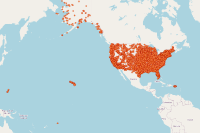

In [13]:
power_plant_wm_item = source.content.get(power_plant_df.loc[3].id)
power_plant_wm_item

Let's use the WebMap object to print information about each of the layers in the Web Map. We'll look at the layer name and the url, specifically paying attention to the beginning of the path componenet of the url, which contains the organization id of the host of the layer.

In [14]:
wm_obj = WebMap(power_plant_wm_item)

In [17]:
for wm_lyr in wm_obj.definition["operationalLayers"]:
    print(f"{wm_lyr['title']}\n{' '*2}{wm_lyr['url']}")
    print(f"{' ' * 2}Host Organization id: {wm_lyr['url'].split('/')[3]}")
    print("\n")

US Power Plants
  https://services7.arcgis.com/JEwYeAy2cc8qOe3o/arcgis/rest/services/US_Power_Plants/FeatureServer/0
  Host Organization id: JEwYeAy2cc8qOe3o




Printing out our source organization id, we can see that the layer in the web map is hosted in the source.

In [18]:
print(f"{source.properties.id}")

JEwYeAy2cc8qOe3o


We can use the `search_existing_items` parameter to handle how we want the items consumed in our `web map` to behave upon cloning. Given what we've learned about this parameter, we can rely on it to detect whether any of the `item ids` consumed in our web maps match any of the `typeKeywords` already existing in our _target_. If the function finds an existing item in the _target_, it will swizzle the appropriate values in the new `web map` definition. If the function does not find an existing item based on the `typeKeyword`, it will clone the `item`. For non-hosted items, it will recreate those items in the resulting `web map`. 

In this case, we'll set it to `False` since we know we've not cloned this web map before. We want any hosted layers to also clone in our _target_.

In [21]:
cloned_wm = target.content.clone_items(items=[power_plant_wm_item],
                                      folder=output_folder.name,
                                      search_existing_items=False)

Let's examine the resulting items in the target:

In [22]:
cloned_wm

[<Item title:"US Power Plants" type:Feature Layer Collection owner:api_data_owner>,
 <Item title:"US Power Plant Data" type:Web Map owner:api_data_owner>]

In [23]:
cloned_wm_obj = WebMap(cloned_wm[1])

In [24]:
for wm_lyr in cloned_wm_obj.definition["operationalLayers"]:
    print(f"{wm_lyr['title']}\n{' '*2}{wm_lyr['url']}")
    print(f"{' ' * 2}Host Organization id: {wm_lyr['url'].split('/')[3]}")
    print("\n")

US Power Plants
  https://pythonapi.playground.esri.com/server/rest/services/Hosted/US_Power_Plants/FeatureServer/0
  Host Organization id: server




We can see that `clone_items()` successfully recreated the web map and cloned the operational layer, and configured the resulting web map to use the cloned feature layer. We can see from the netscheme and path components of the layer URL that the resulting layer is using an ArcGIS Enterprise rather than an ArcGIS Online organization.

Let's visually compare our webmaps:

#### source


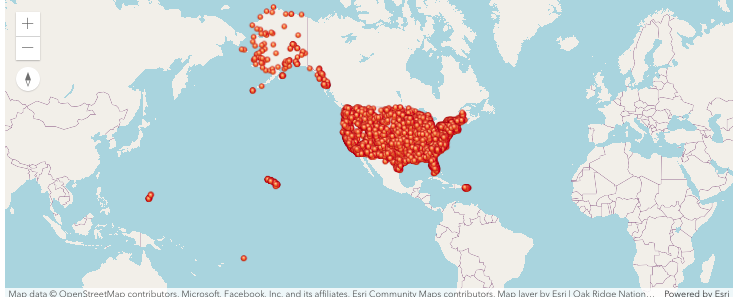

In [16]:
wm_obj

#### target


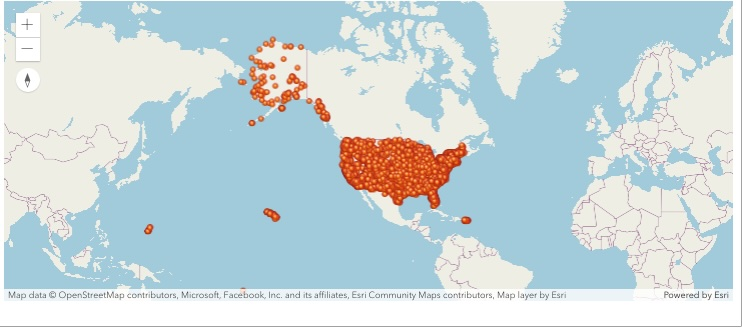

In [31]:
cloned_wm_obj

We can see visually that the maps appear to contain the same layers. You can repeat this process for any other `web map` _source_/_target_ pair from the `wm_map` dictionary to make a visual comparison.

### ArcGIS Dashboards and ArcGIS StoryMaps

See the [Cloning and Troubleshooting Complex Items](../cloning-complex-apps#dashboards-and-editing-item-data) guide for details on cloning ArcGIS Dashboards and ArcGIS StoryMaps. 

## Conclusion

This guide demonstrated one workflow for cloning items between a _source_ Web GIS and a _target_ Web GIS.  We connected to each GIS as an administrator and cloned an individual item, and then a set of items. We then cloned a Web Map item, demonstrating how a hosted feature layer within the web map is also cloned and the cloned web map is configured to read the cloned feature layer which is hosted in the _target_ organization.